deepKernelErf2
deepKernelErf4
deepKernelErf6
deepKernelErf8


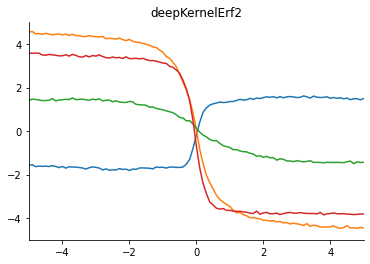

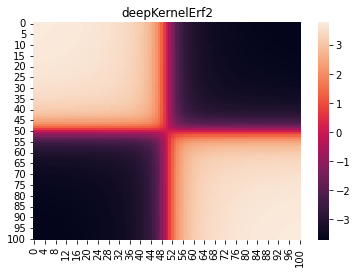

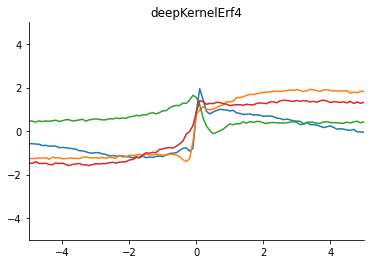

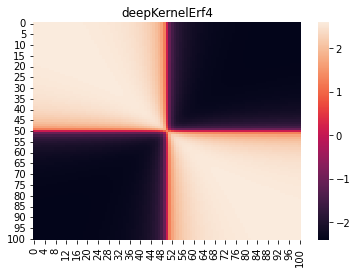

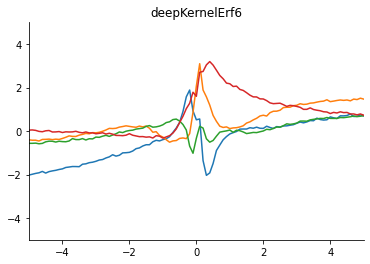

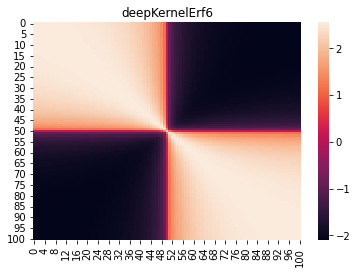

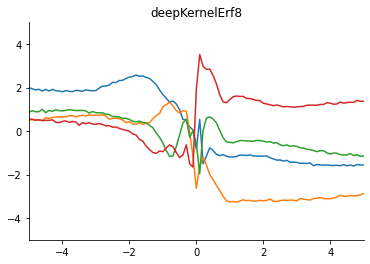

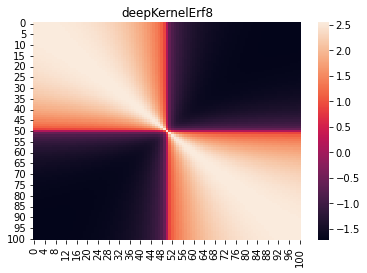

In [6]:
import library.putil as putil
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

xmax = 5
xmin = -5
ymax = 5
ymin = -5
M    = 4
N    = 101
noizeBeta = 0.2

SAVE_FILE = ""

class MyGaussianProcess(torch.nn.Module):
    def __init__(self, kernelName):
        super().__init__()

        # H0 = 1
        self.gaussSigma = nn.Parameter(torch.randn(1))
        self.gaussL = nn.Parameter(torch.randn(1))

        self.periodicSigma = nn.Parameter(torch.randn(1))
        self.periodicL = nn.Parameter(torch.randn(1))
        self.periodicT = nn.Parameter(torch.randn(1) * 5)

        if kernelName == 'gaussian':
            self.kernel = self.kgauss()
        elif kernelName == 'periodic':
            self.kernel = self.kperiodic()
        elif kernelName == 'gaussianPeriodic':
            self.kernel = self.kgaussPlusKperiodic()
        elif kernelName == 'deepKernelErf2':
            self.deepErfL = 2
#            self.deepErfVb = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVb = 0.02 * torch.ones(self.deepErfL)
#            self.deepErfVwHat = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVwHat = 4.0 * torch.ones(self.deepErfL)
            self.kernel = self.kDeepErf()
        
        elif kernelName == 'deepKernelErf4':
            self.deepErfL = 4
#            self.deepErfVb = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVb = 0.02 * torch.ones(self.deepErfL)
#            self.deepErfVwHat = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVwHat = 4.0 * torch.ones(self.deepErfL)
            self.kernel = self.kDeepErf()
            
        elif kernelName == 'deepKernelErf6':
            self.deepErfL = 6
#            self.deepErfVb = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVb = 0.02 * torch.ones(self.deepErfL)
#            self.deepErfVwHat = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVwHat = 4.0 * torch.ones(self.deepErfL)
            self.kernel = self.kDeepErf()
            
        elif kernelName == 'deepKernelErf8':
            self.deepErfL = 8
#            self.deepErfVb = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVb = 0.02 * torch.ones(self.deepErfL)
#            self.deepErfVwHat = nn.Parameter(torch.randn(self.deepErfL))
            self.deepErfVwHat = 4.0 * torch.ones(self.deepErfL)
            self.kernel = self.kDeepErf()
            
        else:
            self.kernel = None
            print("Error : " + kernelName)

    def kDeepErf(self, depth = 1):
        if depth == self.deepErfL:
            retFunc = lambda x, y: self.deepErfVb[depth - 1] + self.deepErfVwHat[depth - 1] * (x * y) # here, dim x = H0 = 1
        else:
            knext = self.kDeepErf(depth + 1)
            retFunc = lambda x, y: self.deepErfVb[depth - 1] + self.deepErfVwHat[depth - 1]\
                * (2 / torch.pi) * torch.arcsin((2 * knext(x, y))\
                / torch.sqrt((1 + 2 * knext(x, x))*(1 + 2 * knext(y, y)))) 
        return retFunc
    
    def kgauss (self):
        # (7.10)
        return lambda x, y: (self.gaussSigma**2) * torch.exp (-(x - y)**2 / (2 * (self.gaussL**2)))

    def kperiodic (self):
        # (7.15)
        return lambda x,y: (self.periodicSigma**2) * torch.exp (- (2 / self.periodicL**2) * (torch.sin(torch.pi / torch.abs(self.periodicT) * (x - y)))**2)

    def kgaussPlusKperiodic (self):
        kgaussFunc = self.kgauss()
        kperiodicFunc = self.kperiodic()

        # (7.16)
        return lambda x,y: kgaussFunc(x, y) + kperiodicFunc(x, y)

    def kernel_matrix (self, xx):
        N = len(xx)
        eta = 1e-3

        # Return K
        # small offset for stability
        return torch.tensor (
            [self.kernel (xi, xj) for xi in xx for xj in xx]
        ).reshape(N,N) + eta * torch.eye(N)

    def fgp (self, xx):
        N = len(xx)
        K = self.kernel_matrix (xx)
        return torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(N), K).sample()

    def fgpGetK(self, xx):
        K = self.kernel_matrix (xx)

        return K

    def negativeLogLikelihood(self):
        def negativeLogLikelihoodSub(xx, ys):
            sampleSize = len(ys)
            tensorKXX = self.fgpGetK(xx) + noizeBeta**2 * torch.eye(sampleSize)
            return 0.5 * (torch.dot(torch.mv(torch.linalg.inv(tensorKXX), ys), ys) + torch.log(torch.linalg.det(tensorKXX)) + sampleSize * torch.log(torch.tensor([2*torch.pi])))
        return negativeLogLikelihoodSub

    def updateParam(self, parameters):

        self.gaussSigma.data = nn.Parameter(next(parameters))
        self.gaussL = nn.Parameter(next(parameters))

        self.periodicSigma = nn.Parameter(next(parameters))
        self.periodicL = nn.Parameter(next(parameters))
        self.periodicT = nn.Parameter(next(parameters))

    def forward(self, x):
        return 1

@torch.no_grad()
def plotKernel(kernelName):
    xx = torch.linspace (xmin, xmax, N)

    fig = plt.figure()
    ax = fig.add_subplot()

    print(kernelName)
    for m in range(M):
        model = MyGaussianProcess(kernelName)
    
        yy = model.fgp (xx)
        plt.plot (xx, yy)

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(kernelName)

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(model.fgpGetK (xx))
    ax.set_title(kernelName)

def main ():
#    kernelName = ['gaussian', 'periodic', 'gaussianPeriodic']
    kernelName = ['deepKernelErf2', 'deepKernelErf4', 'deepKernelErf6', 'deepKernelErf8']
#    kernelName = ['deepKernelErf2', 'deepKernelErf4']
#    kernelName = ['deepKernelErf2']

    for kName in kernelName:
        plotKernel(kName)

    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

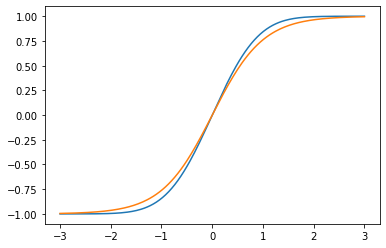

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

xs = np.linspace(-3, 3, 200)

ysErf = 2 * norm.cdf(xs * np.sqrt(2)) - 1
xsExp = np.exp(xs)
ysTanh = (xsExp - 1 / xsExp) / (xsExp + 1 / xsExp)

plt.plot(xs, ysErf)
plt.plot(xs, ysTanh)
plt.show()